In [1]:
import os 

os.chdir('C:\\users\\sarva\\Documents\\Projects\\Opioid Prescriptions\\')

In [2]:
import pandas as pd
import numpy as np

# Import data frames for drug info, provider info

provider = pd.read_csv('prescriber-info.csv')

print(provider['NPI'].head(5))

0    1710982582
1    1245278100
2    1427182161
3    1669567541
4    1679650949
Name: NPI, dtype: int64


In [3]:
# Import NPI Aggregate Report for 2015 from CMS 

npi_agg = pd.read_csv('npi_aggregate_2015.csv')

npi_ref_list = list(npi_agg['National Provider Identifier'])

C:\Users\sarva\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Remove records from provider dataframe whose NPI isn't found in NPI Aggregate Report 2015
# Condense dataset to 17439

retain_row = []

for npi in provider['NPI']:
    if npi not in npi_ref_list:
        retain_row.append(False)
    else:
        retain_row.append(True)
        
provider = provider[retain_row]

provider = provider.set_index('NPI')

print("Length of new provider dataset: {}".format(len(provider)))

print(provider.head())

Length of new provider dataset: 17439
           Gender State Credentials            Specialty  ABILIFY  \
NPI                                                                 
1245278100      F    AL          MD      General Surgery        0   
1669567541      M    AZ          MD    Internal Medicine        0   
1679650949      M    NV        M.D.  Hematology/Oncology        0   
1548580897      M    PA          DO      General Surgery        0   
1437192002      M    NH          MD      Family Practice        0   

            ACETAMINOPHEN.CODEINE  ACYCLOVIR  ADVAIR.DISKUS  AGGRENOX  \
NPI                                                                     
1245278100                      0          0              0         0   
1669567541                     43          0              0         0   
1679650949                      0          0              0         0   
1548580897                      0          0              0         0   
1437192002                      0       

In [5]:
provider = provider.reset_index()

In [6]:
# Use drug_info file to create unique list of all prescribed drugs

drug_info = pd.read_csv('drug_info.csv')

drug_info = drug_info.set_index('Drug Name')

unique_drug_list = drug_info['Generic Name'].unique()

print('Length of unique drug list: {}'.format(len(unique_drug_list)))


# Create unique drug class list - split terms with commas

unique_drug_class = []

for drug_class in drug_info['Drug Class']:
    for i in drug_class.split(','):
        unique_drug_class.append(i.strip())

unique_drug_class = list(set(unique_drug_class))

Length of unique drug list: 215


In [7]:
# Create candidate features dataframe

#FEATURES 1, 2: Count of each unique drug prescribed, and count of each drug class

provider_features = pd.DataFrame(provider['NPI'])

NPI = provider['NPI']

# add column of zeros for each provider for each unique drug and class

for drug in unique_drug_list:
    provider_features[drug] = 0
    
for drug_class in unique_drug_class:
    provider_features[drug_class] = 0
    
# for each provider count prescriptions and assign to correct unique drug column and class

old_drug_list = provider.columns[5:-1]

provider_features = provider_features.set_index('NPI')

npi_count = 0

# for each provider, add prescription count to the generic drug name
# also add count to corresponding drug class - if more than one drug class applies
# add count to each class individually

for npi in NPI:
    for old_drug_name in old_drug_list:
        K = provider[provider['NPI']==npi][old_drug_name]
        if (K != 0).bool():
            provider_features.at[npi, drug_info.at[old_drug_name, 'Generic Name']] += K
            if ',' in drug_info.at[old_drug_name, 'Drug Class']:
                dual_drugs = drug_info.at[old_drug_name, 'Drug Class'].split(',')
                for i in dual_drugs:
                    provider_features.at[npi, i.strip()] += K
            else:
                provider_features.at[npi, drug_info.at[old_drug_name, 'Drug Class']] += K
    npi_count += 1

In [8]:
# Save dataframe with drug and class counts

provider_features.to_pickle("./provider_features.pkl")

In [9]:
# FEATURE 3: Add total prescriptions written by each provider
# determined by summing number of prescriptions for all 215 unique drugs

total_number_presc = []

for npi in NPI:
    total_number_presc.append(sum(provider_features.loc[npi][0:215]))

provider_features['Total Prescriptions'] = total_number_presc

In [10]:
# FEATURES 4,5,6,7: Add percentage of all prescriptions that are opioids, benzodiazepines, barbiturates, other

perc_opioids = []
perc_benzodiazepines = []
perc_barbiturates = []
perc_other = []

for npi in NPI:
    perc_opioids.append(provider_features.at[npi, 'Opioids']/provider_features.at[npi, 'Total Prescriptions'])
    perc_benzodiazepines.append(provider_features.at[npi, 'Benzodiazepines']/provider_features.at[npi, 'Total Prescriptions'])
    perc_barbiturates.append(provider_features.at[npi, 'Barbiturates']/provider_features.at[npi, 'Total Prescriptions'])
    
provider_features['Proportion Opioids'] = perc_opioids
provider_features['Proportion Benzodiazepines'] = perc_benzodiazepines
provider_features['Proportion Barbiturates'] = perc_barbiturates
    
for npi in NPI:
    perc_other.append(1-provider_features.at[npi,'Proportion Opioids']-provider_features.at[npi, 'Proportion Benzodiazepines']
                      -provider_features.at[npi, 'Proportion Barbiturates'])

provider_features['Proportion Other'] = perc_other


In [11]:
provider_features.head()

,Aripiprazole,Acetaminophen-Codeine,Acyclovir,Fluticasone-Salmeterol,Aspirin-Dipyridamole,Alendronate,Allopurinol,Alprazolam,Amiodarone,Amitriptyline,...,Cholesterol Lowering Drugs,Alpha-blockers,Opioids,Antipsychotics,Nitrates,Total Prescriptions,Proportion Opioids,Proportion Benzodiazepines,Proportion Barbiturates,Proportion Other
NPI,,,,,,,,,,,,,,,,,,,,,
1245278100,0,0,0,0,0,0,0,134,0,0,...,0,0,326,0,0,1418,0.229901,0.138928,0.0,0.631171
1669567541,0,43,0,0,0,21,0,0,0,0,...,0,18,469,0,0,1757,0.266932,0.000000,0.0,0.733068
1679650949,0,0,0,0,0,0,0,0,0,19,...,0,0,66,0,0,179,0.368715,0.067039,0.0,0.564246
1548580897,0,0,0,0,0,0,0,0,0,0,...,0,0,25,0,0,25,1.000000,0.000000,0.0,0.000000
1437192002,0,0,0,25,0,0,47,54,0,0,...,16,43,75,24,12,2911,0.025764,0.026108,0.0,0.948128


In [12]:
# Test histogram of one of the 'proportion' variables to confirm correct calculation

import matplotlib.pyplot as plt
import numpy as np

plt.hist(provider_features['Proportion Other'])

(array([  807.,   109.,   274.,   404.,   529.,   564.,   683.,   897.,
         1787., 11385.]),
 array([-5.55111512e-17,  1.00000000e-01,  2.00000000e-01,  3.00000000e-01,
         4.00000000e-01,  5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
         8.00000000e-01,  9.00000000e-01,  1.00000000e+00]),
 <a list of 10 Patch objects>)

In [13]:
# set index of npi_agg table and import us zip codes table

npi_agg = npi_agg.set_index('National Provider Identifier')
uszips = pd.read_csv('uszips.csv').set_index('zip')

In [14]:
# FEATURES 8,9,10: Add provider zip code, county, state

zips = []
county = []
state = []

NPI = provider_features.index

new_provider_features = provider_features.copy()

# lookup zip code and county name according to npi
# if zip code not in reference list (uzips), drop that provider from main features table

for npi in NPI:
    zip_code = str(npi_agg.at[npi, 'Zip Code of the Provider'])[0:5]
    #print("Provider {} is in zip code {}".format(npi, zip_code))
    if int(zip_code) not in uszips.index:
        new_provider_features = new_provider_features.drop(npi)
        #print("Zip code {} not found in list".format(zip_code))
        #print("Dropping provider {}".format(npi))
    else:
        zips.append(zip_code)
        county_name = uszips.at[int(zip_code), 'county_name']
        state_abbr = uszips.at[int(zip_code), 'state_id']
        county.append(county_name + " County, " + state_abbr)
        state.append(state_abbr)
        #print("Adding zip code {} in {} county".format(zip_code, county_name))
    
new_provider_features['Provider Zip Code'] = zips
new_provider_features['Provider County'] = county
new_provider_features['State'] = state


In [15]:
provider_features = new_provider_features

In [16]:
# FEATURE 11: Add county poverty rate 

poverty_rate_county = pd.read_csv('county_poverty_rate.csv').set_index('Geography')
poverty_rate_state = pd.read_csv('state_poverty_rate.csv').set_index('Geography')

county_ref_list = poverty_rate_county.index

average_county_poverty_rate = []

for county_name in county:
    
    if county_name not in county_ref_list:
        average_county_poverty_rate.append(0)
        
    else:
        pov_rate_series = []
        
        pov_rate_series.append(poverty_rate_county.at[county_name, 'Poverty Rate (2013)'])
        pov_rate_series.append(poverty_rate_county.at[county_name, 'Poverty Rate (2014)'])
        pov_rate_series.append(poverty_rate_county.at[county_name, 'Poverty Rate (2015)'])
        pov_rate_series.append(poverty_rate_county.at[county_name, 'Poverty Rate (2016)'])
        pov_rate_series.append(poverty_rate_county.at[county_name, 'Poverty Rate (2017)'])
    
        total = 0
        count = 0
    
        for year in pov_rate_series:
            if year != 0:
                total += year
                count += 1
        average_county_poverty_rate.append(total/count)
        
# for those counties not found or with poverty rate date unavailable, substitute with state average from 2014-2017

average_state_poverty_rate = []

for state in provider_features['State']:
    
        pov_rate_series = []
        
        pov_rate_series.append(poverty_rate_state.at[state, 'Poverty Rate (2013)'])
        pov_rate_series.append(poverty_rate_state.at[state, 'Poverty Rate (2014)'])
        pov_rate_series.append(poverty_rate_state.at[state, 'Poverty Rate (2015)'])
        pov_rate_series.append(poverty_rate_state.at[state, 'Poverty Rate (2016)'])
        pov_rate_series.append(poverty_rate_state.at[state, 'Poverty Rate (2017)'])
        
        total = 0
        count = 0
    
        for year in pov_rate_series:
            if year != 0:
                total += year
                count += 1
        average_state_poverty_rate.append(total/count)
        
for i in range(0, len(provider_features)):
    if average_county_poverty_rate[i]==0:
        average_county_poverty_rate[i] = average_state_poverty_rate[i]
        
provider_features['Average County Poverty Rate'] = average_county_poverty_rate


In [17]:
provider = provider.set_index('NPI')

In [22]:
# FEATURES 12, 13: Add provider gender (M/F) and specialty

gender = []
specialty = []

# update NPI series to reflect new features table 
NPI =  provider_features.index

for npi in NPI:
    gender.append(provider.at[npi, 'Gender'])
    specialty.append(provider.at[npi, 'Specialty'])

provider_features['Gender'] = gender
provider_features['Specialty'] = specialty



In [29]:
# FEATURES 14, 15: Average CSA and WADA scores

# Generate prescription-count (N) weighted averages of each drug risk score

average_wada = []
average_csa = []

drug_info = drug_info.set_index('Generic Name')


for npi in NPI:
    sumproduct_wada = 0
    sumproduct_csa = 0
    for drug in unique_drug_list:
        N = provider_features.at[npi, drug]
        wada = np.mean(drug_info.at[drug, 'WADA'])
        csa = np.mean(drug_info.at[drug, 'CSA Schedule'])
       # print("{} {} {}".format(N, wada, csa))
        
        sumproduct_wada += N * wada
        sumproduct_csa += N * csa
    total_presc = provider_features.at[npi, 'Total Prescriptions']
    average_wada.append(sumproduct_wada / total_presc)
    #if len(average_wada) % 1000 == 0:
    #    print(len(average_wada))
    #print("Sumproduct wada: {}, Total_presc: {}".format(sumproduct_wada, total_presc))
    average_csa.append(sumproduct_csa / total_presc)


provider_features['CSA Score'] = average_csa
provider_features['WADA Score'] = average_wada



In [30]:
# FEATURE 16: Number of unique opioids prescribed
# for each provider count number of unique drugs in 'Opioids' class with >0 prescriptions

unique_opioid_count = []

for npi in NPI:
    count = 0
    for drug in unique_drug_list:
        presc_count = provider_features.at[npi, drug]
        drug_class = drug_info.at[drug, 'Drug Class']
        if (presc_count > 0 and 'Opioids' in drug_class):
            count += 1
    unique_opioid_count.append(count)
#     if len(unique_opioid_count) % 1000 == 0:
#         print(len(unique_opioid_count))
        
provider_features['Unique Opioids Prescribed'] = unique_opioid_count

In [31]:
# FEATURE 17: State opioid overdose death rate

# import CSV list of state names and abbreviations

state_ood_rate = pd.read_csv('state_ood_rate.csv')
state_abbr = pd.read_csv('state_abbr.csv').set_index('State')

state_list = state_abbr.index

state_ood_rate.head()

state_list_ood = []

# join state abbreviations to OOD rate table

for state in state_ood_rate['Geography']:
    state_list_ood.append(state_abbr.at[state, 'Abbreviation'])
    
state_ood_rate['State Abbreviation'] = state_list_ood

state_ood_rate = state_ood_rate.set_index('State Abbreviation')

state_ood_rate.head()

state_ood = []

# drop providers from main table that are not in any of the 50 U.S. states
# update NPI list

new_provider_features = provider_features.copy()

for npi in NPI:
    if new_provider_features.at[npi, 'State'] not in state_abbr['Abbreviation'].values:
       # print(new_provider_features.at[npi, 'State'])
        new_provider_features = new_provider_features.drop(npi)
       # print("Dropped record {}".format(npi))
        
NPI = new_provider_features.index

# create column for state OOD rates in main features table

for npi in NPI:
    # print(npi)
    state_ood.append(state_ood_rate.at[new_provider_features.at[npi, 'State'], 'OOD rate'][0])
    
new_provider_features['State Opioid Overdose Death Rate'] = state_ood

provider_features = new_provider_features

In [32]:
# Pickle (save) features dataset

provider_features.to_pickle("./provider_features.pkl")

provider_features.head(10)

,Aripiprazole,Acetaminophen-Codeine,Acyclovir,Fluticasone-Salmeterol,Aspirin-Dipyridamole,Alendronate,Allopurinol,Alprazolam,Amiodarone,Amitriptyline,...,Provider Zip Code,Provider County,State,Average County Poverty Rate,Gender,Specialty,CSA Score,WADA Score,Unique Opioids Prescribed,State Opioid Overdose Death Rate
NPI,,,,,,,,,,,,,,,,,,,,,
1245278100,0,0,0,0,0,0,0,134,0,0,...,35967,"DeKalb County, AL",AL,0.210443,F,General Surgery,1.388575,0.217207,4,7.500000
1669567541,0,43,0,0,0,21,0,0,0,0,...,85006,"Maricopa County, AZ",AZ,0.158975,M,Internal Medicine,0.763233,0.336938,4,11.400000
1679650949,0,0,0,0,0,0,0,0,0,19,...,89148,"Clark County, NV",NV,0.148788,M,Hematology/Oncology,1.005587,0.245810,3,13.300000
1548580897,0,0,0,0,0,0,0,0,0,0,...,19106,"Philadelphia County, PA",PA,0.259063,M,General Surgery,2.000000,1.000000,1,18.500000
1407113988,0,0,0,0,0,0,0,0,0,0,...,19107,"Philadelphia County, PA",PA,0.259063,F,Nurse Practitioner,0.000000,0.000000,0,18.500000
1023260569,0,0,0,0,0,0,0,0,0,0,...,77018,"Harris County, TX",TX,0.170528,M,Optometry,0.000000,0.229167,0,4.900000
1821106832,0,0,0,11,0,15,22,12,0,0,...,54449,"Wood County, WI",WI,0.106606,F,Internal Medicine,0.194395,0.215747,2,15.800000
1659334472,0,0,0,0,0,0,0,0,0,0,...,75390,"Dallas County, TX",TX,0.176538,M,General Surgery,2.000000,0.000000,1,4.900000
1144205303,0,14,0,0,0,31,29,30,0,20,...,80501,"Boulder County, CO",CO,0.130758,M,Family Practice,0.324855,0.169075,6,9.500000


In [33]:
# import pickle 
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# provider_features = pd.read_pickle('provider_features.pkl')

In [34]:
# EDA: Raw, "interesting facts/statistics"

# proportion of providers who prescribed opioids
prop_presc_opioids = len(provider_features[provider_features['Unique Opioids Prescribed']!=0])/len(provider_features)

opioid_list = []
total = []

# most common and least commonly prescribed opioids
for drug in unique_drug_list:
    if 'Opioids' in drug_info.at[drug, 'Drug Class']:
        opioid_list.append(drug)
        
for opioid in opioid_list:
    total.append(sum(provider_features[opioid].values))
    
opioid_prescriptions_count = pd.DataFrame({'Opioid': opioid_list, 'Count': total})
opioid_prescriptions_count = opioid_prescriptions_count.sort_values(['Count'], ascending=False).reset_index()


# specialties with most and least opioid prescriptions (for those in specialty with at least 100 prescriptions)
specialty_list = list(set(provider_features['Specialty']))
total = []

for specialty in specialty_list:
    total.append(len(provider_features[provider_features['Specialty']==specialty]
                     [provider_features['Unique Opioids Prescribed']!=0][provider_features['Total Prescriptions']
                                                                        >=0])/
                 len(provider_features[provider_features['Specialty']==specialty]))
    
specialty_opioid_prop = pd.DataFrame({'Specialty': specialty_list, 'Prescribed Opioids': total}).sort_values(['Prescribed Opioids'], ascending=False).reset_index()


# male vs female opioid prescription rate

gender_list = ['M', 'F']
total = []

for gender in gender_list:
    total.append(len(provider_features[provider_features['Gender']==gender]
                     [provider_features['Unique Opioids Prescribed']!=0])/
                 len(provider_features))
                 
gender_opioid_prop = pd.DataFrame({'Gender': gender_list, 'Prescribed Opioids': total})

print("The percent of all providers sampled who wrote prescriptions for opioid(s) in 2015 is: {}".format(prop_presc_opioids))
print("The most commonly prescribed opioid is {}. The least commonly prescribed opioid is {}"
      .format(opioid_prescriptions_count['Opioid'][0], opioid_prescriptions_count['Opioid'][len(opioid_prescriptions_count)-1]))
print("The specialty whose doctors/providers most commonly prescribed opioids were Geriatric Medicine (86%) and Pain Management (84%).")
print("The specialty whose doctors/providers least commonly prescribed opioids were Psychiatry (7%) and Immunology (4%).")
print("Male providers prescribed opioids at a rate more than twice that of female providers (37.4% vs 17.3%).")
print("Average CSA score of all providers: {}".format(np.mean(provider_features['CSA Score'])))
print("Average WADA score of all providers: {}".format(np.mean(provider_features['WADA Score'])))
print("Of those providers who prescribed opioids in 2015, the provider prescribed {} unique opioid drugs on average."
     .format(np.mean(provider_features['Unique Opioids Prescribed'][provider_features['Unique Opioids Prescribed']!=0])))

C:\Users\sarva\Anaconda\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\sarva\Anaconda\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


The percent of all providers sampled who wrote prescriptions for opioid(s) in 2015 is: 0.5472906403940887
The most commonly prescribed opioid is Hydrocodone-Acetaminophen. The least commonly prescribed opioid is Hydromorphone
The specialty whose doctors/providers most commonly prescribed opioids were Geriatric Medicine (86%) and Pain Management (84%).
The specialty whose doctors/providers least commonly prescribed opioids were Psychiatry (7%) and Immunology (4%).
Male providers prescribed opioids at a rate more than twice that of female providers (37.4% vs 17.3%).
Average CSA score of all providers: 0.4862271122941667
Average WADA score of all providers: 0.1589676678756462
Of those providers who prescribed opioids in 2015, the provider prescribed 2.3034428442844286 unique opioid drugs on average.


C:\Users\sarva\Anaconda\lib\site-packages\ipykernel_launcher.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


C:\Users\sarva\Anaconda\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


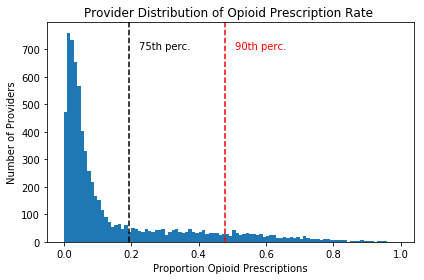

In [165]:
# EDA: Test variable histograms

# Distribution of provider opioid prescription rate variable (>100 prescriptions)

import matplotlib.pyplot as plt

provider_features_w_opioid = provider_features[provider_features['Proportion Opioids']>0][provider_features['Total Prescriptions']>100]

prop_opioids = provider_features_w_opioid['Proportion Opioids']

fig, ax = plt.subplots()

num_bins = 100

# the histogram of the data
plt.hist(prop_opioids, bins=np.arange(0,1,0.01))

plt.axvline(x=np.percentile(prop_opioids,75), color='black', linestyle='--')
plt.axvline(x=np.percentile(prop_opioids,90), color='red', linestyle='--')

plt.text(np.percentile(prop_opioids,75)+0.03, 700, '75th perc.', color='black')
plt.text(np.percentile(prop_opioids,90)+0.03, 700, '90th perc.', color='red')

plt.xlabel('Proportion Opioid Prescriptions')
plt.ylabel('Number of Providers')
plt.title(r'Provider Distribution of Opioid Prescription Rate ')

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()

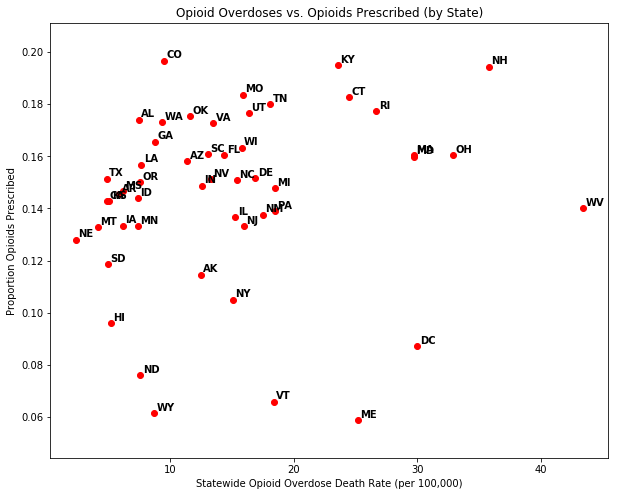

In [167]:
# EDA Test Proportion Opioids vs. State Opioid Overdose Death Rate (for providers with >=100 total prescriptions)


   # PLOT 1 #
#-------------
# opioids_prop_county = provider_features_w_opioid[['Provider County',
#                                                  'Proportion Opioids', 
#                                                  'Average County Poverty Rate']].groupby(by='Provider County').mean()

# plt.scatter(opioids_prop_county['Average County Poverty Rate'],
#             opioids_prop_county['Proportion Opioids'], alpha=0.5)
# plt.title('Poverty Rate vs. Opioids Prescribed (by County)')
# plt.xlabel('County Poverty Rate')
# plt.ylabel('Proportion Opioids Prescribed')

# opioids_prop_state = provider_features_w_opioid[['State',
#                                                  'Proportion Opioids', 
#                                                  'State Opioid Overdose Death Rate']].groupby(by='State').mean()
#----------------


   # PLOT 2 #
#----------------    
plt.figure(figsize=(10,8))

plt.scatter(opioids_prop_state['State Opioid Overdose Death Rate'],
            opioids_prop_state['Proportion Opioids'], alpha=1.00, color='red')
plt.title('Opioid Overdoses vs. Opioids Prescribed (by State)')
plt.xlabel('Statewide Opioid Overdose Death Rate (per 100,000)')
plt.ylabel('Proportion Opioids Prescribed')

for state in opioids_prop_state.index:
    plt.text(opioids_prop_state.at[state, 'State Opioid Overdose Death Rate']+0.2, opioids_prop_state.at[state, 'Proportion Opioids']+0.001, state, weight='bold')
#-----------------


   # PLOT 3 #
# #----------------    
# plt.figure(figsize=(8,6))

# CSA = provider_features_w_opioid['CSA Score']

# plt.hist(CSA, bins=np.arange(0,5,0.1))
# plt.title('Distribution of Provider CSA Risk Score')
# plt.xlabel('CSA Average Score')
# plt.ylabel('Number of Providers')

# plt.axvline(x=np.percentile(CSA,75), color='black', linestyle='--')
# plt.axvline(x=np.percentile(CSA,90), color='red', linestyle='--')

# plt.text(np.percentile(CSA,75)+0.03, 1000, '75th perc.', color='black')
# plt.text(np.percentile(CSA,90)+0.03, 1000, '90th perc.', color='red')

   # PLOT 4 #
#----------------    
# plt.figure(figsize=(8,6))

# WADA = provider_features_w_opioid['WADA Score']

# plt.hist(WADA, bins=np.arange(0,1,0.01))
# plt.title('Distribution of Provider WADA Risk Score')
# plt.xlabel('WADA Average Score')
# plt.ylabel('Number of Providers')
# plt.xlim(0,1)

# plt.axvline(x=np.percentile(WADA,75), color='black', linestyle='--')
# plt.axvline(x=np.percentile(WADA,90), color='red', linestyle='--')

# plt.text(np.percentile(WADA,75)-0.1, 600, '75th perc.', color='black')
# plt.text(np.percentile(WADA,90)+0.01, 600, '90th perc.', color='red')

In [180]:
# EDA: Most common opioids prescribed in states arranged by overdose death rate
# Refer to Excel sheet for graphs

# create state list
npi_state = []

for npi in provider_features_w_opioid.index:
    npi_state.append(provider_features_w_opioid.at[npi, 'State'])
    
# subset w/ opioid provider features table for only opioid drug counts and aggregate by state

provider_features_w_opioid_op_count = provider_features_w_opioid[opioid_list]
provider_features_w_opioid_op_count['State'] = npi_state

opioid_by_state = provider_features_w_opioid_op_count.groupby(by='State').sum()

# create new columns for proportion of each opioid by state

newvar = []

for opioid in opioid_list:
    newvar = []
    column_name = 'Proportion of ' + opioid
    for state in opioid_by_state.index:
        newvar.append(opioid_by_state.at[state, opioid] / opioid_by_state.loc[state].sum(axis=0))
    opioid_by_state[column_name] = newvar    
    
    
opioid_by_state.to_csv('opioid_by_state.csv')


# Add additional features for proportion of Fentanyl, Oxycodone, Oxycodone-Acetaminophen to main table

prop_fentanyl = []
prop_oxy = []
prop_oxyacet = []

# add proportion of all opioids prescribed for three drugs: Fentanyl, Oxycodone, Oxycodone-Acetaminophen

for npi in NPI:
    if provider_features.at[npi, 'Opioids']==0:
        prop_fentanyl.append(0)
        prop_oxy.append(0)
        prop_oxyacet.append(0)
    else:
        prop_fentanyl.append(provider_features.at[npi, 'Fentanyl']/provider_features.at[npi,'Opioids'])
        prop_oxy.append(provider_features.at[npi, 'Oxycodone']/provider_features.at[npi,'Opioids'])
        prop_oxyacet.append(provider_features.at[npi, 'Oxycodone-Acetaminophen']/provider_features.at[npi,'Opioids'])
    
    
provider_features['Proportion Fentanyl'] = prop_fentanyl
provider_features['Proportion Oxycodone'] = prop_oxy
provider_features['Proportion Oxycodone-Acetaminophen'] = prop_oxyacet


provider_features.head(20)


C:\Users\sarva\Anaconda\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


,Aripiprazole,Acetaminophen-Codeine,Acyclovir,Fluticasone-Salmeterol,Aspirin-Dipyridamole,Alendronate,Allopurinol,Alprazolam,Amiodarone,Amitriptyline,...,Specialty,CSA Score,WADA Score,Unique Opioids Prescribed,State Opioid Overdose Death Rate,Proportion Fentanyl,Proportion Oxycodone,Proportion Oxycodone-Acetaminophen,Regrouped Specialty,Specialty Relativity
NPI,,,,,,,,,,,,,,,,,,,,,
1245278100,0,0,0,0,0,0,0,134,0,0,...,General Surgery,1.388575,0.217207,4,7.500000,0.000000,0.266871,0.101227,Other,2.051862
1669567541,0,43,0,0,0,21,0,0,0,0,...,Internal Medicine,0.763233,0.336938,4,11.400000,0.000000,0.061834,0.488273,Internal Medicine,7.650498
1679650949,0,0,0,0,0,0,0,0,0,19,...,Hematology/Oncology,1.005587,0.245810,3,13.300000,0.333333,0.333333,0.000000,Other,3.290771
1548580897,0,0,0,0,0,0,0,0,0,0,...,General Surgery,2.000000,1.000000,1,18.500000,0.000000,0.000000,1.000000,Other,8.924970
1407113988,0,0,0,0,0,0,0,0,0,0,...,Nurse Practitioner,0.000000,0.000000,0,18.500000,0.000000,0.000000,0.000000,Nurse Practitioner,0.000000
1023260569,0,0,0,0,0,0,0,0,0,0,...,Optometry,0.000000,0.229167,0,4.900000,0.000000,0.000000,0.000000,Other,0.000000
1821106832,0,0,0,11,0,15,22,12,0,0,...,Internal Medicine,0.194395,0.215747,2,15.800000,0.694444,0.305556,0.000000,Internal Medicine,0.458981
1659334472,0,0,0,0,0,0,0,0,0,0,...,General Surgery,2.000000,0.000000,1,4.900000,0.000000,0.000000,0.000000,Other,8.924970
1144205303,0,14,0,0,0,31,29,30,0,20,...,Family Practice,0.324855,0.169075,6,9.500000,0.074866,0.090909,0.117647,Family Practice,1.276103


In [198]:
# EDA: Opioid prescriptions by specialty

# Number of providers of each specialty

count_specialty_prescriptions = provider_features[['Specialty','Total Prescriptions']].groupby(by=['Specialty']).sum().sort_values(by='Total Prescriptions', ascending=False)

specialty_cat = count_specialty_prescriptions[count_specialty_prescriptions['Total Prescriptions']>=93600].index

new_specialty = []

for npi in NPI:
    if provider_features.at[npi, 'Specialty'] in specialty_cat:
        new_specialty.append(provider_features.at[npi, 'Specialty'])
    else:
        new_specialty.append('Other')
        
provider_features['Regrouped Specialty'] = new_specialty
        
provider_features_specialty = provider_features[['Opioids', 'Total Prescriptions']]
        
provider_features_specialty['Specialty Category'] = new_specialty

provider_features_specialty = provider_features_specialty.groupby(by=['Specialty Category']).sum()

prop = []

for specialty in provider_features_specialty.index:
    prop.append(provider_features_specialty.at[specialty, 'Opioids']/provider_features_specialty.at[specialty, 'Total Prescriptions'])

provider_features_specialty['Proportion Opioids'] = prop

provider_features_specialty = provider_features_specialty.sort_values(by='Proportion Opioids',ascending=False)

provider_features_specialty

C:\Users\sarva\Anaconda\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Opioids,Total Prescriptions,Proportion Opioids
Specialty Category,,,
Pain Management,53353,93697,0.569421
Anesthesiology,63495,118380,0.536366
Interventional Pain Management,49258,97424,0.505604
Physical Medicine and Rehabilitation,79925,170616,0.468450
Orthopedic Surgery,68177,166651,0.409100
Emergency Medicine,54387,358895,0.151540
Other,95682,853959,0.112045
Rheumatology,21247,232323,0.091455
Physician Assistant,66265,819232,0.080887


In [182]:
# Add "relativity" feature for opioids specialty

specialty_relativity = []

for npi in NPI:
    specialty_relativity.append(provider_features.at[npi, 'Proportion Opioids']/
        provider_features_specialty.at[provider_features.at[npi, 'Regrouped Specialty'],'Proportion Opioids'])
    
provider_features['Specialty Relativity'] = specialty_relativity

In [183]:
# Subset provider features table to only those with 1000 or more prescriptions

prov_400 = provider_features[provider_features['Total Prescriptions']>=400]

print(len(prov_400))

prov_400[prov_400['Specialty Relativity']==max(prov_400['Specialty Relativity'])]


# Drop records with relativities greater than a certain level

np.percentile(prov_400['Specialty Relativity'], 99.9)

NPI_400 = prov_400.index

for npi in NPI_400:
    if prov_400.at[npi, 'Specialty Relativity'] > 20:
        prov_400 = prov_400.drop(npi)

len(prov_400)

prov_400[prov_400['Specialty Relativity']==max(prov_400['Specialty Relativity'])]

7952


,Aripiprazole,Acetaminophen-Codeine,Acyclovir,Fluticasone-Salmeterol,Aspirin-Dipyridamole,Alendronate,Allopurinol,Alprazolam,Amiodarone,Amitriptyline,...,Specialty,CSA Score,WADA Score,Unique Opioids Prescribed,State Opioid Overdose Death Rate,Proportion Fentanyl,Proportion Oxycodone,Proportion Oxycodone-Acetaminophen,Regrouped Specialty,Specialty Relativity
NPI,,,,,,,,,,,,,,,,,,,,,
1518042282,74,0,0,0,0,0,0,150,0,14,...,Psychiatry,1.358877,0.085736,4,9.4,0.096591,0.210227,0.0,Psychiatry,19.815627


In [184]:
# Create finalized input feature table

prov_400.columns[295:]


input_features = prov_400[['Proportion Opioids', 'Proportion Benzodiazepines', 'Proportion Barbiturates',
                          'Proportion Other','CSA Score','WADA Score','Unique Opioids Prescribed',
                          'Proportion Fentanyl','Proportion Oxycodone','Proportion Oxycodone-Acetaminophen',
                          'Specialty Relativity']]

input_features_twovar = prov_400[['Proportion Opioids', 'Proportion Oxycodone']]

In [185]:
# Full K-means clustering model
# Hyperparameter selection (SSEs: Elbow Method)
# Decision Tree Results

# Scale input data

input_features_array = np.array(input_features)

from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()

X_scaled = min_max_scaler.fit_transform(input_features_array)

# import dill
# dill.dump_session('notebook_env.db')

Text(0,0.5,'Proportion of Opioids = Oxycodone')

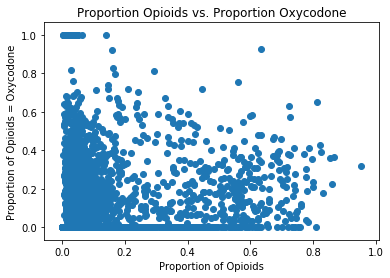

In [186]:
# Test on 2-var with visualization (plot)

plt.scatter(input_features_twovar['Proportion Opioids'], input_features_twovar['Proportion Oxycodone'])
plt.title('Proportion Opioids vs. Proportion Oxycodone')
plt.xlabel('Proportion of Opioids')
plt.ylabel('Proportion of Opioids = Oxycodone')

In [187]:
X_twovar_scaled = min_max_scaler.fit_transform(input_features_twovar)

In [188]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0).fit_predict(X_twovar_scaled)

C:\Users\sarva\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Text(0,0.5,'Proporion Oxycodone Prescriptions')

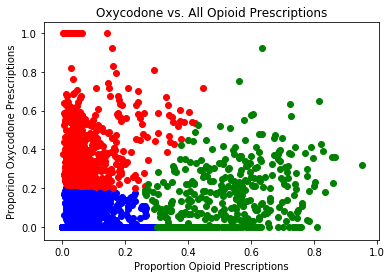

In [189]:
input_features_twovar['Kmeans Label']=kmeans


X0=input_features_twovar['Proportion Opioids'][kmeans==0]
Y0=input_features_twovar['Proportion Oxycodone'][kmeans==0]

X1=input_features_twovar['Proportion Opioids'][kmeans==1]
Y1=input_features_twovar['Proportion Oxycodone'][kmeans==1]

X2=input_features_twovar['Proportion Opioids'][kmeans==2]
Y2=input_features_twovar['Proportion Oxycodone'][kmeans==2]

plt.scatter(X0, Y0, color='blue')
plt.scatter(X1, Y1, color='red')
plt.scatter(X2, Y2, color='green')
plt.title('Oxycodone vs. All Opioid Prescriptions')
plt.xlabel('Proportion Opioid Prescriptions')
plt.ylabel('Proporion Oxycodone Prescriptions')

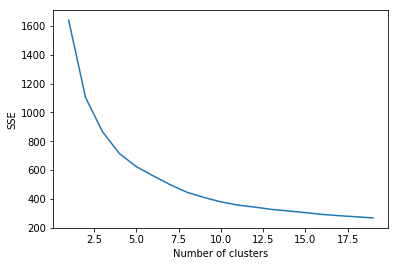

In [190]:
sse = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(X_scaled)
    sse.append(kmeans.inertia_) # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(np.arange(1,20,1), sse)
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

In [191]:
# Scale input features data using MinMaxScaler

from sklearn import preprocessing
from sklearn.cluster import KMeans

min_max_scaler = preprocessing.MinMaxScaler()

X_scaled = min_max_scaler.fit_transform(input_features_array)

# Fit K-Means model with k = 7 to data and generate output labels (classes)

kmeans = KMeans(n_clusters=7, max_iter=1000).fit(X_scaled)
labels = kmeans.labels_

# List names of all input features in final model

print(input_features.columns)

Index(['Proportion Opioids', 'Proportion Benzodiazepines',
       'Proportion Barbiturates', 'Proportion Other', 'CSA Score',
       'WADA Score', 'Unique Opioids Prescribed', 'Proportion Fentanyl',
       'Proportion Oxycodone', 'Proportion Oxycodone-Acetaminophen',
       'Specialty Relativity'],
      dtype='object')


In [192]:
# implement  decision tree to determine separating conditions betwen clusters

from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0, max_depth=3)

clf.fit(input_features_array,labels)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [193]:
from sklearn import tree
import graphviz 


dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=input_features.columns,  
                                class_names=['1','2','3','4','5','6','7'],  
                                filled=True, rounded=True,  
                                special_characters=True
                               )
graph = graphviz.Source(dot_data)  
#this will create an iris.pdf file with the rule path
graph.render("iris")

'iris.pdf'

In [194]:
input_features.columns

Index(['Proportion Opioids', 'Proportion Benzodiazepines',
       'Proportion Barbiturates', 'Proportion Other', 'CSA Score',
       'WADA Score', 'Unique Opioids Prescribed', 'Proportion Fentanyl',
       'Proportion Oxycodone', 'Proportion Oxycodone-Acetaminophen',
       'Specialty Relativity'],
      dtype='object')

In [195]:
input_features.columns

Index(['Proportion Opioids', 'Proportion Benzodiazepines',
       'Proportion Barbiturates', 'Proportion Other', 'CSA Score',
       'WADA Score', 'Unique Opioids Prescribed', 'Proportion Fentanyl',
       'Proportion Oxycodone', 'Proportion Oxycodone-Acetaminophen',
       'Specialty Relativity'],
      dtype='object')

In [196]:
provider_features.head(50)

,Aripiprazole,Acetaminophen-Codeine,Acyclovir,Fluticasone-Salmeterol,Aspirin-Dipyridamole,Alendronate,Allopurinol,Alprazolam,Amiodarone,Amitriptyline,...,Specialty,CSA Score,WADA Score,Unique Opioids Prescribed,State Opioid Overdose Death Rate,Proportion Fentanyl,Proportion Oxycodone,Proportion Oxycodone-Acetaminophen,Regrouped Specialty,Specialty Relativity
NPI,,,,,,,,,,,,,,,,,,,,,
1245278100,0,0,0,0,0,0,0,134,0,0,...,General Surgery,1.388575,0.217207,4,7.500000,0.000000,0.266871,0.101227,Other,2.051862
1669567541,0,43,0,0,0,21,0,0,0,0,...,Internal Medicine,0.763233,0.336938,4,11.400000,0.000000,0.061834,0.488273,Internal Medicine,7.650498
1679650949,0,0,0,0,0,0,0,0,0,19,...,Hematology/Oncology,1.005587,0.245810,3,13.300000,0.333333,0.333333,0.000000,Other,3.290771
1548580897,0,0,0,0,0,0,0,0,0,0,...,General Surgery,2.000000,1.000000,1,18.500000,0.000000,0.000000,1.000000,Other,8.924970
1407113988,0,0,0,0,0,0,0,0,0,0,...,Nurse Practitioner,0.000000,0.000000,0,18.500000,0.000000,0.000000,0.000000,Nurse Practitioner,0.000000
1023260569,0,0,0,0,0,0,0,0,0,0,...,Optometry,0.000000,0.229167,0,4.900000,0.000000,0.000000,0.000000,Other,0.000000
1821106832,0,0,0,11,0,15,22,12,0,0,...,Internal Medicine,0.194395,0.215747,2,15.800000,0.694444,0.305556,0.000000,Internal Medicine,0.458981
1659334472,0,0,0,0,0,0,0,0,0,0,...,General Surgery,2.000000,0.000000,1,4.900000,0.000000,0.000000,0.000000,Other,8.924970
1144205303,0,14,0,0,0,31,29,30,0,20,...,Family Practice,0.324855,0.169075,6,9.500000,0.074866,0.090909,0.117647,Family Practice,1.276103


In [197]:
provider_features.columns

Index(['Aripiprazole', 'Acetaminophen-Codeine', 'Acyclovir',
       'Fluticasone-Salmeterol', 'Aspirin-Dipyridamole', 'Alendronate',
       'Allopurinol', 'Alprazolam', 'Amiodarone', 'Amitriptyline',
       ...
       'Specialty', 'CSA Score', 'WADA Score', 'Unique Opioids Prescribed',
       'State Opioid Overdose Death Rate', 'Proportion Fentanyl',
       'Proportion Oxycodone', 'Proportion Oxycodone-Acetaminophen',
       'Regrouped Specialty', 'Specialty Relativity'],
      dtype='object', length=314)

In [178]:
provider_features.loc[1518042282]

Aripiprazole                                       74
Acetaminophen-Codeine                               0
Acyclovir                                           0
Fluticasone-Salmeterol                              0
Aspirin-Dipyridamole                                0
Alendronate                                         0
Allopurinol                                         0
Alprazolam                                        150
Amiodarone                                          0
Amitriptyline                                      14
Amlodipine                                          0
Amlodipine-Benazepril                               0
Amoxicillin                                         0
Amoxicillin-Clavulanate                             0
Amphetamine                                        54
Atenolol                                            0
Atorvastatin                                        0
Dutasteride                                         0
Azithromycin                